## Fair phenotyping demo
To assess whether a computational labelling function is necessarily fair given protected attributes, we intend to compute fairness metrics (equalized odds, etc) for the outputs of any given labeler. Because true labels (of whether a patient had a particular disease) are subject to differences in disease diagnosis criteria, we use multiple phenotype definitions, similar to [this paper](https://proceedings.neurips.cc//paper/2020/file/03593ce517feac573fdaafa6dcedef61-Paper.pdf). Following the logic of the aforementioned paper, if the **majority** of phenotypes classify a given patient at a given timestep as having diabetes, we use that as our best proxy of a true label.

For the purposes of this demo, for diabetes phenotypes I used:
1.  The [2004 Miller phenotype](https://github.com/OHDSI/PhenotypeLibrary/blob/master/inst/201826000/201826007.json). On Radak-W, this is cohort 33333.
2.  The OHDSI LEGEND-based [diabetes definition](https://github.com/OHDSI/PhenotypeLibrary/blob/master/inst/201826000/201826005.json). On Radak-W, this is cohort 33334.
3.  An old [PheKB definition](https://github.com/OHDSI/PhenotypeLibrary/blob/master/inst/201826000/201826006.json). On Radak-W, this is cohort 33335.

In [1]:
from getpass import getpass
import os
from keyrings.cryptfile.cryptfile import CryptFileKeyring

In [2]:
kr = CryptFileKeyring()
kr.keyring_key = os.getenv("KEYRING_CRYPTFILE_PASSWORD") or getpass()

In [3]:
import keyring
import pandas as pd
import pyodbc

In [4]:
keyring.set_keyring(kr)

In [5]:
connection_string = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=#######;'
    'DATABASE=ohdsi_cumc_2021q1r2;'
    'UID=#####;'
    f"PWD={keyring.get_password('#####', '#####')};"
)

In [52]:
conn = pyodbc.connect(connection_string)

In [7]:
# todo - merge all into one table with separate cohort_ids
sql_query_string = 'select * from ohdsi_cumc_2021q1r2.results.diabetes_example'

subset_df = pd.io.sql.read_sql(sql_query_string, conn)

In [8]:
len(subset_df)

264915

In [10]:
for i in range(33333, 33336):
    print(len(subset_df[subset_df.cohort_definition_id == i]))

126364
132395
6156


In [11]:
# For each of these existing data [33333, 33334, 33335] let's get a sense of the overlap
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [13]:
%matplotlib inline

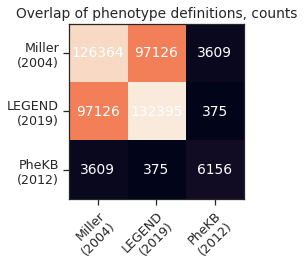

In [390]:
y_axis = ["Miller\n(2004)", "LEGEND\n(2019)", "PheKB\n(2012)"]
x_axis = ["Miller\n(2004)", "LEGEND\n(2019)", "PheKB\n(2012)"]

values = np.zeros((3, 3), dtype=int)
for i, cohort_id_i in enumerate([33333, 33334, 33335]):
    for j, cohort_id_j in enumerate([33333, 33334, 33335]):
        A = set(subset_df[subset_df.cohort_definition_id == cohort_id_i].subject_id.unique())
        B = set(subset_df[subset_df.cohort_definition_id == cohort_id_j].subject_id.unique())
        values[i][j] = len(A.intersection(B))

fig, ax = plt.subplots()
im = ax.imshow(values)

# We want to show all ticks...
ax.set_xticks(np.arange(len(x_axis)))
ax.set_yticks(np.arange(len(y_axis)))
# ... and label them with the respective list entries
ax.set_xticklabels(x_axis)
ax.set_yticklabels(y_axis)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(x_axis)):
    for j in range(len(y_axis)):
        text = ax.text(j, i, values[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Overlap of phenotype definitions, counts")
fig.tight_layout()
plt.show()

In [15]:
A = set(subset_df[subset_df.cohort_definition_id == 33333].subject_id.unique())
B = set(subset_df[subset_df.cohort_definition_id == 33334].subject_id.unique())
C = set(subset_df[subset_df.cohort_definition_id == 33335].subject_id.unique())
shared = A.intersection(B).intersection(C)

In [16]:
len(shared)

365

In [19]:
len(list(A))

126364

In [23]:
# # Let's pull the demographic data for patients in A, B, and C

In [24]:
sql_query_string = 'select * from ohdsi_cumc_2021q1r2.results.diabetes_demographics where cohort_definition_id = 33333'
demo_A = pd.io.sql.read_sql(sql_query_string, conn)

In [25]:
sql_query_string = 'select * from ohdsi_cumc_2021q1r2.results.diabetes_demographics where cohort_definition_id = 33334'
demo_B = pd.io.sql.read_sql(sql_query_string, conn)

In [26]:
sql_query_string = 'select * from ohdsi_cumc_2021q1r2.results.diabetes_demographics where cohort_definition_id = 33335'
demo_C = pd.io.sql.read_sql(sql_query_string, conn)

In [55]:
# Let's just grab everybody, as per today's discussion
sql_query_string = "select person_id, gender_concept_id, race_concept_id, ethnicity_concept_id from ohdsi_cumc_2021q1r2.dbo.person"
everybody = pd.io.sql.read_sql(sql_query_string, conn)

In [27]:
# We also need patients that are _not_ diabetes patients. For a fair comparison,
# I chose patients who also had at least 365 days of continuous observation.

sql_query_string = "select * from ohdsi_cumc_2021q1r2.results.oneyearprior"
oneyearprior = pd.io.sql.read_sql(sql_query_string, conn)

In [59]:
# oneyear_ids = set(oneyearprior.subject_id.unique())
# negative_ids = oneyear_ids - A - B - C
all_ids = set(everybody.person_id.unique())
negative_ids = all_ids - A - B - C

In [61]:
# It's not perfect, but this is a proof of concept.
len(A.union(B).union(C)), len(oneyear_ids), len(all_ids), len(negative_ids)

(164170, 248707, 6747059, 6582889)

In [66]:
# 8507 = Men, 8532 = Women
len(everybody[everybody.gender_concept_id == 8507].person_id.unique()), len(everybody[everybody.gender_concept_id == 8532].person_id.unique())

(2971591, 3758402)

In [31]:
# Let's pull the demographic data for negative_ids patients
# I did this in SQL to be faster.

# # select count(t2.gender_concept_id)
# # from ohdsi_cumc_2021q1r2.dbo.person t2
# #     inner join ohdsi_cumc_2021q1r2.results.oneyearprior t1
# #         on t1.subject_id = t2.person_id
# # where not exists ( select null
# #                    from ohdsi_cumc_2021q1r2.results.crohns_example t3
# #                    WHERE t3.subject_id = t2.person_id ) and
# # t2.gender_concept_id = 8507
# # t2.gender_concept_id = 8532

# women_negative_count = 160491
# men_negative_count = 86998

In [67]:
# select count(t2.gender_concept_id)
# from ohdsi_cumc_2021q1r2.dbo.person t2
#     inner join ohdsi_cumc_2021q1r2.results.oneyearprior t1
#         on t1.subject_id = t2.person_id
# where t2.gender_concept_id = 8507

# men_total_1year = 87495
# women_total_1year = 161133
men_total = 2971591
women_total = 3758402

In [70]:
# Let's assess the demographic parity for A, B, and C
#
# Quoting the PAKDD lecture, the fundamental idea is that the proportion of each protected class 
# should receive the positive (and negative) outcomes at equal rates. 

# Let class 0 be men (8507), class 1 be women (8532)

diffs = []

for phenotype in [demo_A, demo_B, demo_C]:
    class_0_prop_outcome = len(phenotype[phenotype.gender_concept_id == 8507]) / (men_total_1year)
    class_1_prop_outcome = len(phenotype[phenotype.gender_concept_id == 8532]) / (women_total_1year)
    print('Men: ' + str(class_0_prop_outcome))
    print('Women: ' + str(class_1_prop_outcome))
    print('Diff: ' + str(class_1_prop_outcome - class_0_prop_outcome))
    diffs.append(class_1_prop_outcome - class_0_prop_outcome)

Men: 0.6325275730041716
Women: 0.44056152371022694
Diff: -0.19196604929394467
Men: 0.7003600205726042
Women: 0.44112627456821385
Diff: -0.2592337460043903
Men: 0.0370306874678553
Women: 0.018090645615733588
Diff: -0.018940041852121715


Text(0, 0.5, 'Phenotype algorithm')

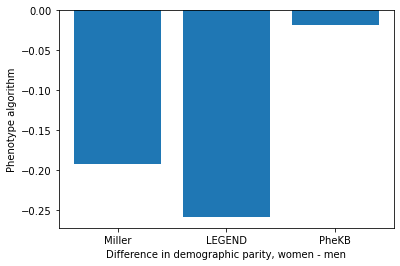

In [71]:
plt.bar(["Miller", "LEGEND", "PheKB"], diffs)
plt.xlabel('Difference in demographic parity, women - men')
plt.ylabel('Phenotype algorithm')

In [35]:
# Let's assess the equality of opportunity for A, B, and C
#
# Again quoting the PAKDD lecture, equalized odds is when the predicted output of the model is independent of
# the protected attribute conditional on the data. This definition is restrictive because it’s hard to
# calculate conditional independence, so there is instead a relaxed version
# (also known as the Equality of Opportunity) which is used instead.
# We need the true definitions. In this case, the true cases are majority class for the phenotypes,
# or the set of patients that are in AB, AC, or BC:

AB = set(A.intersection(B))
AC = set(A.intersection(C))
BC = set(B.intersection(C))
Y  = set(AB.union(AC)).union(BC)

In [36]:
len(Y)

100380

In [37]:
full_df = pd.concat((demo_A[demo_A.person_id.isin(Y)], demo_B[demo_B.person_id.isin(Y)], demo_C[demo_C.person_id.isin(Y)])).drop_duplicates()

In [38]:
len(phenotype[(phenotype.gender_concept_id == 8507) & (phenotype.person_id.isin(Y))])

1775

In [39]:
len(full_df[full_df.gender_concept_id == 8507])

95273

In [40]:
# Let class 0 be men (8507), class 1 be women (8532)

diffs = []

for phenotype in [demo_A, demo_B, demo_C]:
    class_0_eqq_opp = len(phenotype[(phenotype.gender_concept_id == 8507) & (phenotype.person_id.isin(Y))]) / len(full_df[full_df.gender_concept_id == 8507])
    class_1_eqq_opp = len(phenotype[(phenotype.gender_concept_id == 8532) & (phenotype.person_id.isin(Y))]) / len(full_df[full_df.gender_concept_id == 8532])
    print('Men: ' + str(class_0_eqq_opp))
    print('Women: ' + str(class_1_eqq_opp))
    print('Diff: ' + str(class_1_eqq_opp - class_0_eqq_opp))
    diffs.append(class_1_eqq_opp - class_0_eqq_opp)

Men: 0.4990605942921919
Women: 0.4990264466246999
Diff: -3.4147667491990497e-05
Men: 0.4823087338490443
Women: 0.4835535643395905
Diff: 0.0012448304905461893
Men: 0.018630671858763763
Women: 0.01741998903570956
Diff: -0.0012106828230542023


Text(0, 0.5, 'Phenotype algorithm')

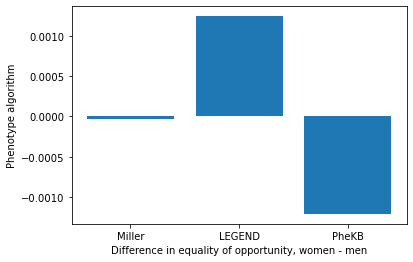

In [41]:
plt.bar(["Miller", "LEGEND", "PheKB"], diffs)
plt.xlabel('Difference in equality of opportunity, women - men')
plt.ylabel('Phenotype algorithm')

In [42]:
# Again quoting the PAKDD lecture, predictive rate parity (or sufficiency) means that the true label
# is independent of the protected attribute conditional on the predicted outputs.

diffs = []

for phenotype in [demo_A, demo_B, demo_C]:
    class_0_prp = len(phenotype[(phenotype.gender_concept_id == 8507) & (phenotype.person_id.isin(Y))]) / len(phenotype[phenotype.gender_concept_id == 8507])
    class_1_prp = len(phenotype[(phenotype.gender_concept_id == 8532) & (phenotype.person_id.isin(Y))]) / len(phenotype[phenotype.gender_concept_id == 8532])
    print('Men: ' + str(class_0_prp))
    print('Women: ' + str(class_1_prp))
    print('Diff: ' + str(class_1_prp - class_0_prp))
    diffs.append(class_1_prp - class_0_prp)

Men: 0.8591330430226045
Women: 0.7437208581611235
Diff: -0.11541218486148097
Men: 0.7498776069715068
Women: 0.7197383230163197
Diff: -0.03013928395518717
Men: 0.5478395061728395
Women: 0.6322469982847342
Diff: 0.08440749211189469


Text(0, 0.5, 'Phenotype algorithm')

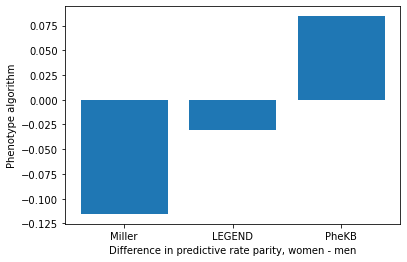

In [43]:
plt.bar(["Miller", "LEGEND", "PheKB"], diffs)
plt.xlabel('Difference in predictive rate parity, women - men')
plt.ylabel('Phenotype algorithm')

In [44]:
conn.close()

In [320]:
from statsmodels.stats.proportion import proportions_ztest

In [321]:
cutoff = 0.05

In [332]:
column_names = ["Miller\n(2004)", "LEGEND\n(2019)", "PheKB\n(2012)"]

In [322]:
# Let's assess the demographic parity for A, B, and C
#
# Quoting the PAKDD lecture, the fundamental idea is that the proportion of each protected class 
# should receive the positive (and negative) outcomes at equal rates. 

# Let class 0 be men (8507), class 1 be women (8532)

diffs_dp = []
all_vals_dp = []
pvals_dp = []


for phenotype in [demo_A, demo_B, demo_C]:
    class_0_prop_outcome = len(phenotype[phenotype.gender_concept_id == 8507]) / (men_total)
    class_1_prop_outcome = len(phenotype[phenotype.gender_concept_id == 8532]) / (women_total)
    print('Men: ' + str(class_0_prop_outcome))
    print('Women: ' + str(class_1_prop_outcome))
    print('Diff: ' + str(class_1_prop_outcome - class_0_prop_outcome))
    diffs_dp.append(class_1_prop_outcome - class_0_prop_outcome)
    all_vals_dp.append((class_1_prop_outcome, class_0_prop_outcome))
    
    count = np.array([len(phenotype[phenotype.gender_concept_id == 8507]), len(phenotype[phenotype.gender_concept_id == 8532])])
    nobs = np.array([men_total, women_total])
    stat, pval = proportions_ztest(count, nobs)
    pvals_dp.append(pval)

Men: 0.018624030022974226
Women: 0.018888080625755307
Diff: 0.0002640506027810803
Men: 0.020621276615792685
Women: 0.018912293043692505
Diff: -0.0017089835721001805
Men: 0.0010903250144451238
Women: 0.0007755955855706761
Diff: -0.0003147294288744477


In [323]:
import seaborn as sns

In [366]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

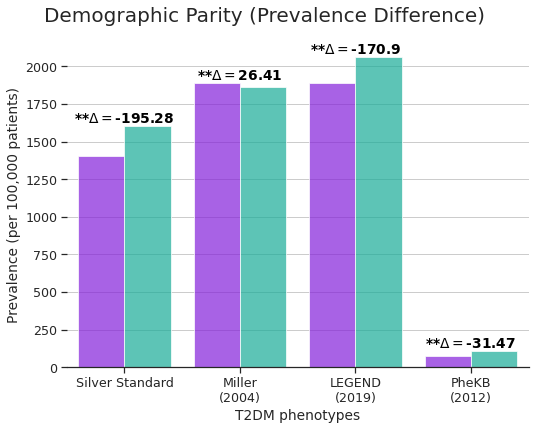

In [367]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'T2DM phenotypes': column_names, 
                         'women': [x[0] * 100000 for x in all_vals_dp], 
                         'men': [x[1] * 100000 for x in all_vals_dp]})

dfs1 = pd.melt(dfs, id_vars = "T2DM phenotypes", var_name='gender', value_name='Prevalence (per 100,000 patients)')

men_silver = len(full_df[full_df.gender_concept_id == 8507].subject_id.unique()) / men_total * 100000
women_silver = len(full_df[full_df.gender_concept_id == 8532].subject_id.unique()) / women_total * 100000

count = np.array([len(full_df[full_df.gender_concept_id == 8507].person_id.unique()), 
                  len(full_df[full_df.gender_concept_id == 8532].person_id.unique())])
nobs = np.array([men_total, women_total])
stat, pval_silver = proportions_ztest(count, nobs)


tmp = dfs1.append({'T2DM phenotypes' : 'Silver Standard', 'gender' : 'women', 'Prevalence (per 100,000 patients)' : women_silver}, ignore_index=True)
tmp = tmp.append({'T2DM phenotypes' : 'Silver Standard', 'gender' : 'men', 'Prevalence (per 100,000 patients)' : men_silver}, ignore_index=True)

category_order = ["Silver Standard", "Miller\n(2004)", "LEGEND\n(2019)", "PheKB\n(2012)"]

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'T2DM phenotypes', y='Prevalence (per 100,000 patients)', 
               hue = 'gender', data=tmp, kind='bar', order = category_order,
               palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(women_silver, xmin=0, xmax=3, linestyle = '--', color = '#8700f9', label = 'silver standard (women)')
# plt.axhline(men_silver, xmin=0, xmax=3, linestyle = '--', color = '#00c4aa', label = 'silver standard (men)')

# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Demographic Parity (Prevalence Difference)')


# plt.text(0, 1910, "$\Delta = $" + str(np.round(diffs_dp[0] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(1, 2075, "$\Delta = $" + str(np.round(diffs_dp[1] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(2, 125, "$\Delta = $" + str(np.round(diffs_dp[2] * 100000, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(2, 1650, "$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(0.03, all_vals_dp[0][1] * 100000, "]", horizontalalignment='center', size='medium', color='black', fontsize = 8)


# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
#labels=["women","men", "women silver standard", "men silver standard"])

if pval_silver < cutoff:
    plt.text(0, np.round(max(women_silver, men_silver), 0) + 25, "**$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black', weight='bold')
else:
    plt.text(0, np.round(max(women_silver, men_silver), 0) + 25, "$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black')
    
for i, ele in enumerate(all_vals_dp):
    part1 = "$\Delta = $" + str(np.round(diffs_dp[i] * 100000, 2))
    part2 = "$p = $" + str(np.round(pvals_dp[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_dp[i] < cutoff:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 25, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 25, part1, horizontalalignment='center', size='medium', color='black')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

plt.savefig('../png/t2dm_demographic_parity.png', dpi=300, bbox_inches = 'tight')
plt.show()


In [368]:
# Let class 0 be men (8507), class 1 be women (8532)

diffs_eqq_opp = []
all_vals_eqq_opp = []
pvals_eqq_opp = []

for phenotype in [demo_A, demo_B, demo_C]:
    class_0_nom = len(phenotype[(phenotype.gender_concept_id == 8507) & (phenotype.person_id.isin(Y))].person_id.unique())
    class_0_denom = len(full_df[full_df.gender_concept_id == 8507].person_id.unique())
    class_1_nom = len(phenotype[(phenotype.gender_concept_id == 8532) & (phenotype.person_id.isin(Y))].person_id.unique())
    class_1_denom = len(full_df[full_df.gender_concept_id == 8532].person_id.unique())
    class_0_eqq_opp = class_0_nom / class_0_denom
    class_1_eqq_opp = class_1_nom / class_1_denom
    print('Men: ' + str(class_0_eqq_opp))
    print('Women: ' + str(class_1_eqq_opp))
    print('Diff: ' + str(class_1_eqq_opp - class_0_eqq_opp))
    diffs_eqq_opp.append(class_1_eqq_opp - class_0_eqq_opp)
    all_vals_eqq_opp.append((class_1_eqq_opp, class_0_eqq_opp))
    
    count = np.array([class_0_nom, class_1_nom])
    nobs = np.array([class_0_denom, class_1_denom])
    stat, pval = proportions_ztest(count, nobs)
    pvals_eqq_opp.append(pval)

pvals_eqq_opp = np.nan_to_num(pvals_eqq_opp, nan=1)

Men: 0.9999158797922231
Women: 0.9998863679406083
Diff: -2.9511851614816287e-05
Men: 0.9663519168892347
Women: 0.9688837544032423
Diff: 0.00253183751400754
Men: 0.037328342201005234
Women: 0.034903980909814024
Diff: -0.00242436129119121


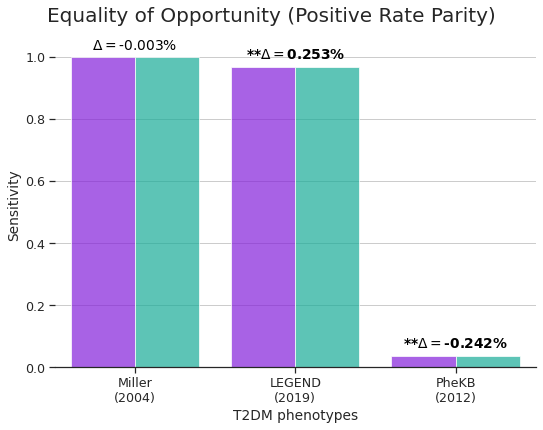

In [369]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'T2DM phenotypes': column_names, 
                         'women': [x[0] for x in all_vals_eqq_opp], 
                         'men': [x[1] for x in all_vals_eqq_opp]})

dfs1 = pd.melt(dfs, id_vars = "T2DM phenotypes", var_name='gender', value_name='Sensitivity')

men_silver = len(full_df[(full_df.gender_concept_id == 8507) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.gender_concept_id == 8507].subject_id.unique())
women_silver = len(full_df[(full_df.gender_concept_id == 8532) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.gender_concept_id == 8532].subject_id.unique())

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'T2DM phenotypes', y='Sensitivity', 
               hue = 'gender', data=dfs1, kind='bar', 
               palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(women_silver, xmin=0, xmax=3, linestyle = '--', color = '#8700f9', label = 'women silver standard', alpha = 0.8)
# plt.axhline(men_silver, xmin=0, xmax=3, linestyle = '--', color = '#00c4aa', label = 'men silver standard', alpha = 0.5)
# plt.axhline(1, xmin=0, xmax=3, linestyle = '-', color = 'black', label = 'silver standard', alpha = 0.5)
# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Equality of Opportunity (Positive Rate Parity)')

for i, ele in enumerate(all_vals_eqq_opp):
    part1 = "$\Delta = $" + str(np.round(diffs_eqq_opp[i] * 100, 3)) + '%'
    part2 = "$p = $" + str(np.round(pvals_eqq_opp[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_eqq_opp[i] < cutoff:
        plt.text(i, max(ele[0], ele[1]) + 0.025, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i, max(ele[0], ele[1]) + 0.025, part1, horizontalalignment='center', size='medium', color='black')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

# plt.text(0, 1.025, "$\Delta = $" + str(np.round(diffs_eqq_opp[0] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(1, 1.025, "$\Delta = $" + str(np.round(diffs_eqq_opp[1] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(2, 0.05, "$\Delta = $" + str(np.round(diffs_eqq_opp[2] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')

plt.savefig('../png/t2dm_equality_opportunity.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [370]:
# Again quoting the PAKDD lecture, predictive rate parity (or sufficiency) means that the true label
# is independent of the protected attribute conditional on the predicted outputs.

diffs_prp = []
all_vals_prp = []
pvals_prp = []

for phenotype in [demo_A, demo_B, demo_C]:
    class_0_nom = len(phenotype[(phenotype.gender_concept_id == 8507) & (phenotype.person_id.isin(Y))])
    class_0_denom = len(phenotype[phenotype.gender_concept_id == 8507])
    class_1_nom = len(phenotype[(phenotype.gender_concept_id == 8532) & (phenotype.person_id.isin(Y))])
    class_1_denom = len(phenotype[phenotype.gender_concept_id == 8532])
    class_0_prp =  class_0_nom / class_0_denom
    class_1_prp =  class_1_nom / class_1_denom
    print('Men: ' + str(class_0_prp))
    print('Women: ' + str(class_1_prp))
    print('Diff: ' + str(class_1_prp - class_0_prp))
    diffs_prp.append(class_1_prp - class_0_prp)
    all_vals_prp.append((class_1_prp, class_0_prp))
    
    count = np.array([class_0_nom, class_1_nom])
    nobs = np.array([class_0_denom, class_1_denom])
    stat, pval = proportions_ztest(count, nobs)
    pvals_prp.append(pval)

pvals_prp = np.nan_to_num(pvals_prp, nan=1)

Men: 0.8591330430226045
Women: 0.7437208581611235
Diff: -0.11541218486148097
Men: 0.7498776069715068
Women: 0.7197383230163197
Diff: -0.03013928395518717
Men: 0.5478395061728395
Women: 0.6322469982847342
Diff: 0.08440749211189469


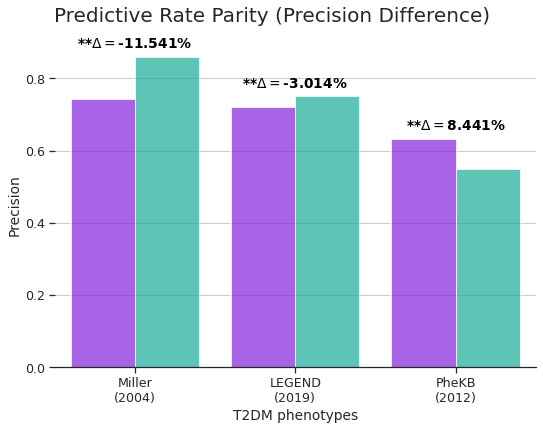

In [371]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'T2DM phenotypes': column_names, 
                         'women': [x[0] for x in all_vals_prp], 
                         'men': [x[1] for x in all_vals_prp]})

dfs1 = pd.melt(dfs, id_vars = "T2DM phenotypes", var_name='gender', value_name='Precision')

men_silver = len(full_df[(full_df.gender_concept_id == 8507) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.gender_concept_id == 8507].subject_id.unique())
women_silver = len(full_df[(full_df.gender_concept_id == 8532) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.gender_concept_id == 8532].subject_id.unique())

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'T2DM phenotypes', y='Precision', 
               hue = 'gender', data=dfs1, kind='bar', 
               palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(women_silver, xmin=0, xmax=3, linestyle = '--', color = '#8700f9', label = 'women silver standard', alpha = 0.8)
# plt.axhline(men_silver, xmin=0, xmax=3, linestyle = '--', color = '#00c4aa', label = 'men silver standard', alpha = 0.5)
# plt.axhline(1, xmin=0, xmax=3, linestyle = '-', color = 'black', label = 'silver standard', alpha = 0.5)
# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Predictive Rate Parity (Precision Difference)')

for i, ele in enumerate(all_vals_prp):
    part1 = "$\Delta = $" + str(np.round(diffs_prp[i] * 100, 3)) + '%'
    part2 = "$p = $" + str(np.round(pvals_prp[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_prp[i] < cutoff:
        plt.text(i, max(ele[0], ele[1]) + 0.025, '**' + part1, horizontalalignment='center', 
                 size='medium', color='black', weight='bold')
    else:
        plt.text(i, max(ele[0], ele[1]) + 0.025, part1, horizontalalignment='center', size='medium', color='black')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

# plt.text(0, 0.875, "$\Delta = $" + str(np.round(diffs_prp[0] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(1, 0.76, "$\Delta = $" + str(np.round(diffs_prp[1] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(2, 0.65, "$\Delta = $" + str(np.round(diffs_prp[2] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')

plt.savefig('../png/t2dm_pred_rate_parity.png', dpi=300, bbox_inches = 'tight')

# handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)

# plt.savefig('../png/t2dm_pred_rate_parity_legend.png', dpi=300, bbox_inches = 'tight')

#labels=["women","men", "women silver standard", "men silver standard"])

plt.show()

In [340]:
# fig, ax = plt.subplots()
# # ax.plot(range(10))

# fig.patch.set_visible(False)
# ax.axis('off')

# #specify order of items in legend
# order = [2,3,0,1]

# fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
# fig.savefig('../png/legend_women_men.png', dpi=300, bbox_inches = 'tight')

In [341]:
# race_source_value == WHITE
# race_source_concept_id == 4.0 [8527]

# VS

# race_source_value == BLACK OR AFRICAN AMERICAN
# race_source_concept_id == 3.0 [8516]

len(demo_A[demo_A.race_source_concept_id == 4.0]), len(demo_A[demo_A.race_source_concept_id == 3.00])

(42150, 15515)

In [342]:
# 8527 = white, 8516 = Black
len(everybody[everybody.race_concept_id == 8527].person_id.unique()), len(everybody[everybody.race_concept_id == 8516].person_id.unique())

(1069661, 380926)

In [343]:
white_total = 1069661
Black_total = 380926

In [344]:
# Let's assess the demographic parity for A, B, and C across white vs Black
#
# Quoting the PAKDD lecture, the fundamental idea is that the proportion of each protected class 
# should receive the positive (and negative) outcomes at equal rates. 

# Let class 0 be white (4.0), class 1 be Black (3.0)

diffs_dp_race = []
all_vals_dp_race = []
p_vals_dp_race = []

for phenotype in [demo_A, demo_B, demo_C]:
    class_0_prop_outcome = len(phenotype[phenotype.race_source_concept_id == 4.0]) / (white_total)
    class_1_prop_outcome = len(phenotype[phenotype.race_source_concept_id == 3.0]) / (Black_total)
    diffs_dp_race.append(class_1_prop_outcome - class_0_prop_outcome)
    all_vals_dp_race.append((class_1_prop_outcome, class_0_prop_outcome))
    
    count = np.array([len(phenotype[phenotype.race_source_concept_id == 4.0]), 
                      len(phenotype[phenotype.race_source_concept_id == 3.0])])
    nobs = np.array([white_total, Black_total])
    stat, pval = proportions_ztest(count, nobs)
    p_vals_dp_race.append(pval)

p_vals_dp_race = np.nan_to_num(p_vals_dp_race, nan=1)

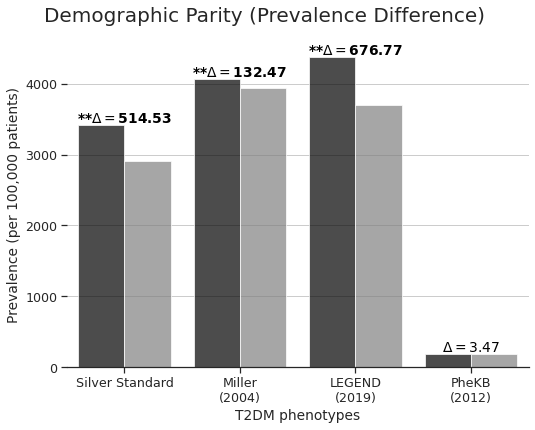

In [388]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'T2DM phenotypes': column_names, 
                         'Black': [x[0] * 100000 for x in all_vals_dp_race], 
                         'white': [x[1] * 100000 for x in all_vals_dp_race]})

dfs1 = pd.melt(dfs, id_vars = "T2DM phenotypes", var_name='race', value_name='Prevalence (per 100,000 patients)')

white_silver = len(full_df[full_df.race_source_concept_id == 4.0].subject_id.unique()) / white_total * 100000
black_silver = len(full_df[full_df.race_source_concept_id == 3.0].subject_id.unique()) / Black_total * 100000

count = np.array([len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique()), 
                  len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique())])
nobs = np.array([white_total, Black_total])
stat, pval_silver = proportions_ztest(count, nobs)


tmp = dfs1.append({'T2DM phenotypes' : 'Silver Standard', 'race' : 'Black', 'Prevalence (per 100,000 patients)' : black_silver}, ignore_index=True)
tmp = tmp.append({'T2DM phenotypes' : 'Silver Standard', 'race' : 'white', 'Prevalence (per 100,000 patients)' : white_silver}, ignore_index=True)

category_order = [x for x in column_names]
category_order.insert(0, "Silver Standard")

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'T2DM phenotypes', y='Prevalence (per 100,000 patients)', 
               hue = 'race', data=tmp, kind='bar', order = category_order,
               palette=sns.color_palette(['black', 'grey']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(black_silver, xmin=0, xmax=3, linestyle = '--', color = 'black', label = 'silver standard (Black)')
# plt.axhline(white_silver, xmin=0, xmax=3, linestyle = '--', color = 'grey', label = 'silver standard (white)')

# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Demographic Parity (Prevalence Difference)')


# plt.text(0, 4100, "$\Delta = $" + str(np.round(diffs_dp_race[0] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(1, 4450, "$\Delta = $" + str(np.round(diffs_dp_race[1] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(2, 250, "$\Delta = $" + str(np.round(diffs_dp_race[2] * 100000, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(2, 3500, "$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(0.03, all_vals_dp[0][1] * 100000, "]", horizontalalignment='center', size='medium', color='black', fontsize = 8)


# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
#labels=["women","men", "women silver standard", "men silver standard"])

if pval_silver < cutoff:
    plt.text(0, np.round(max(black_silver, white_silver), 0) + 25, "**$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black', weight='bold')
else:
    plt.text(0, np.round(max(black_silver, white_silver), 0) + 25, "$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black')
    
for i, ele in enumerate(all_vals_dp_race):
    part1 = "$\Delta = $" + str(np.round(diffs_dp_race[i] * 100000, 2))
    part2 = "$p = $" + str(np.round(p_vals_dp_race[i], 4))
    full_str = part1 + '\n' + part2 
    if p_vals_dp_race[i] < cutoff:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 25, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 25, part1, horizontalalignment='center', size='medium', color='black')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

plt.savefig('../png/t2dm_demographic_parity_race.png', dpi=300, bbox_inches = 'tight')
plt.show()


In [373]:
# Let class 0 be white, class 1 be black

diffs_eqq_opp_race = []
all_vals_eqq_opp_race = []
pvals_eqq_opp_race = []

for phenotype in [demo_A, demo_B, demo_C]:
    class_0_eqq_opp = len(phenotype[(phenotype.race_source_concept_id == 4.0) & (phenotype.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique())
    class_1_eqq_opp = len(phenotype[(phenotype.race_source_concept_id == 3.0) & (phenotype.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique())
    diffs_eqq_opp_race.append(class_1_eqq_opp - class_0_eqq_opp)
    all_vals_eqq_opp_race.append((class_1_eqq_opp, class_0_eqq_opp))
    
    count = np.array([len(phenotype[(phenotype.race_source_concept_id == 4.0) & (phenotype.person_id.isin(Y))].person_id.unique()), 
                      len(phenotype[(phenotype.race_source_concept_id == 3.0) & (phenotype.person_id.isin(Y))].person_id.unique())])
    nobs = np.array([len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique()), len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique())])
    stat, pval = proportions_ztest(count, nobs)
    pvals_eqq_opp_race.append(pval)

pvals_eqq_opp_race = np.nan_to_num(pvals_eqq_opp_race, nan=1)

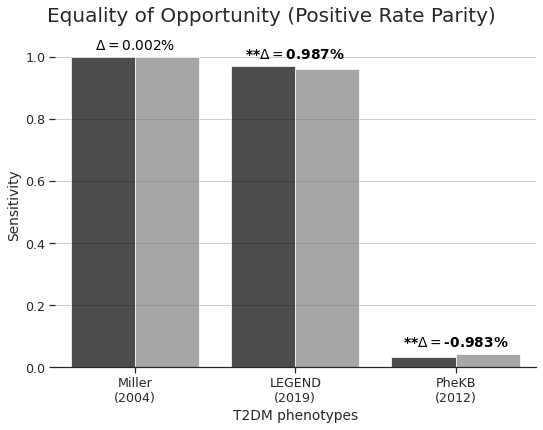

In [374]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'T2DM phenotypes': column_names, 
                         'Black': [x[0] for x in all_vals_eqq_opp_race], 
                         'white': [x[1] for x in all_vals_eqq_opp_race]})

dfs1 = pd.melt(dfs, id_vars = "T2DM phenotypes", var_name='race', value_name='Sensitivity')

white_silver = len(full_df[(full_df.race_source_concept_id == 4.0) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.race_source_concept_id == 4.0].subject_id.unique())
black_silver = len(full_df[(full_df.race_source_concept_id == 3.0) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.race_source_concept_id == 3.0].subject_id.unique())

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'T2DM phenotypes', y='Sensitivity', 
               hue = 'race', data=dfs1, kind='bar', 
               palette=sns.color_palette(['black', 'grey']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(black_silver, xmin=0, xmax=3, linestyle = '--', color = 'black', label = 'black silver standard', alpha = 0.8)
# plt.axhline(white_silver, xmin=0, xmax=3, linestyle = '--', color = 'grey', label = 'white silver standard', alpha = 0.5)
# plt.axhline(1, xmin=0, xmax=3, linestyle = '-', color = 'black', label = 'silver standard', alpha = 0.5)
# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Equality of Opportunity (Positive Rate Parity)')

# plt.text(0, 1.025, "$\Delta = $" + str(np.round(diffs_eqq_opp_race[0] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(1, 1.025, "$\Delta = $" + str(np.round(diffs_eqq_opp_race[1] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(2, 0.05, "$\Delta = $" + str(np.round(diffs_eqq_opp_race[2] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')

for i, ele in enumerate(all_vals_eqq_opp_race):
    part1 = "$\Delta = $" + str(np.round(diffs_eqq_opp_race[i] * 100, 3)) + '%'
    part2 = "$p = $" + str(np.round(pvals_eqq_opp_race[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_eqq_opp_race[i] < cutoff:
        plt.text(i, max(ele[0], ele[1]) + 0.025, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i, max(ele[0], ele[1]) + 0.025, part1, horizontalalignment='center', size='medium', color='black')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

plt.savefig('../png/t2dm_equality_opportunity_race.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [375]:
# Again quoting the PAKDD lecture, predictive rate parity (or sufficiency) means that the true label
# is independent of the protected attribute conditional on the predicted outputs.

diffs_prp_race = []
all_vals_prp_race = []
pvals_prp_race = []

for phenotype in [demo_A, demo_B, demo_C]:
    class_0_prp = len(phenotype[(phenotype.race_source_concept_id == 4.0) & (phenotype.person_id.isin(Y))]) / len(phenotype[phenotype.race_source_concept_id == 4.0])
    class_1_prp = len(phenotype[(phenotype.race_source_concept_id == 3.0) & (phenotype.person_id.isin(Y))]) / len(phenotype[phenotype.race_source_concept_id == 3.0])
    diffs_prp_race.append(class_1_prp - class_0_prp)
    all_vals_prp_race.append((class_1_prp, class_0_prp))
    
    count = np.array([len(phenotype[(phenotype.race_source_concept_id == 4.0) & (phenotype.person_id.isin(Y))]), 
                      len(phenotype[(phenotype.race_source_concept_id == 3.0) & (phenotype.person_id.isin(Y))])])
    nobs = np.array([len(phenotype[phenotype.race_source_concept_id == 4.0]), len(phenotype[phenotype.race_source_concept_id == 3.0])])
    stat, pval = proportions_ztest(count, nobs)
    pvals_prp_race.append(pval)

pvals_prp_race = np.nan_to_num(pvals_prp_race, nan=1)

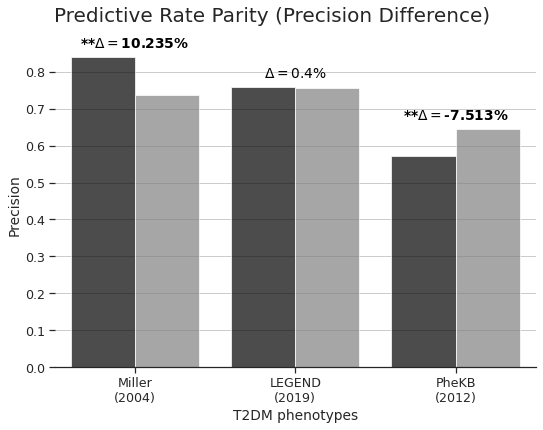

In [376]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'T2DM phenotypes': column_names, 
                         'Black': [x[0] for x in all_vals_prp_race], 
                         'white': [x[1] for x in all_vals_prp_race]})

dfs1 = pd.melt(dfs, id_vars = "T2DM phenotypes", var_name='race', value_name='Precision')

white_silver = len(full_df[(full_df.race_source_concept_id == 4.0) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.race_source_concept_id == 4.0].subject_id.unique())
black_silver = len(full_df[(full_df.race_source_concept_id == 3.0) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.race_source_concept_id == 3.0].subject_id.unique())

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'T2DM phenotypes', y='Precision', 
               hue = 'race', data=dfs1, kind='bar', 
               palette=sns.color_palette(['black', 'grey']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(black_silver, xmin=0, xmax=3, linestyle = '--', color = 'black', label = 'Black silver standard')
# plt.axhline(white_silver, xmin=0, xmax=3, linestyle = '--', color = 'grey', label = 'white silver standard')
# plt.axhline(1, xmin=0, xmax=3, linestyle = '-', color = 'black', label = 'silver standard', alpha = 0.5)
# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Predictive Rate Parity (Precision Difference)')

# plt.text(0, 0.85, "$\Delta = $" + str(np.round(diffs_prp_race[0] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(1, 0.77, "$\Delta = $" + str(np.round(diffs_prp_race[1] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(2, 0.65, "$\Delta = $" + str(np.round(diffs_prp_race[2] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')

for i, ele in enumerate(all_vals_prp_race):
    part1 = "$\Delta = $" + str(np.round(diffs_prp_race[i] * 100, 3)) + '%'
    part2 = "$p = $" + str(np.round(pvals_prp_race[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_prp_race[i] < cutoff:
        plt.text(i, max(ele[0], ele[1]) + 0.025, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i, max(ele[0], ele[1]) + 0.025, part1, horizontalalignment='center', size='medium', color='black')


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

plt.savefig('../png/t2dm_pred_rate_parity_race.png', dpi=300, bbox_inches = 'tight')

# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)

# plt.savefig('../png/t2dm_pred_rate_parity_legend_race.png', dpi=300, bbox_inches = 'tight')

# #labels=["women","men", "women silver standard", "men silver standard"])

# plt.show()

In [364]:
# race_source_value == WHITE
# race_source_concept_id == 4.0 [8527]

# VS

# race_source_value == BLACK OR AFRICAN AMERICAN
# race_source_concept_id == 3.0 [8516]


for i, phenotype in enumerate([demo_A, demo_B, demo_C]):
    print('i:' + column_names[i])
    print('nwomen: ' + str(len(phenotype[phenotype.gender_concept_id == 8532].person_id.unique())))
    print('nmen: ' + str(len(phenotype[phenotype.gender_concept_id == 8507].person_id.unique())))
    print('nblack: ' + str(len(phenotype[phenotype.race_source_concept_id == 3.0].person_id.unique())))
    print('nwhite: ' + str(len(phenotype[phenotype.race_source_concept_id == 4.0].person_id.unique())))

i:Miller
(2004)
nwomen: 70989
nmen: 55343
nblack: 15515
nwhite: 42150
i:LEGEND
(2019)
nwomen: 71080
nmen: 61278
nblack: 16676
nwhite: 39588
i:PheKB
(2012)
nwomen: 2915
nmen: 3240
nblack: 729
nwhite: 2010


In [365]:
from datetime import datetime
from time import time

for i, phenotype in enumerate([demo_A, demo_B, demo_C]):
    print('i:' + column_names[i])
    births = phenotype.birth_datetime
    ages = []
    for ele in births:
        age = np.datetime64(datetime.now()) - np.datetime64(ele)
        age = age.astype('timedelta64[Y]')
        age_int = age / np.timedelta64(1, 'Y')
        ages.append(age_int)
    
    tot = len(ages)
    print(np.round(len([x for x in ages if x <= 18]) / tot * 100, 2))
    print(np.round(len([x for x in ages if x > 18 and x <=30]) / tot * 100, 2)) 
    print(np.round(len([x for x in ages if x > 30 and x <=60]) / tot * 100, 2)) 
    print(np.round(len([x for x in ages if x > 60 and x <=80]) / tot * 100, 2))
    print(np.round(len([x for x in ages if x >= 80]) / tot * 100, 2))

i:Miller
(2004)
0.54
2.51
25.83
43.71
29.4
i:LEGEND
(2019)
0.69
1.87
21.13
43.53
34.82
i:PheKB
(2012)
0.5
1.9
27.58
47.69
24.32


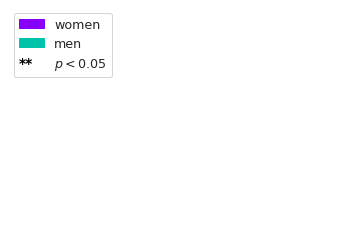

In [377]:
fig, ax = plt.subplots()
# ax.plot(range(10))

fig.patch.set_visible(False)
ax.axis('off')

# manually define a new patch 
# https://stackoverflow.com/questions/27174425/how-to-add-a-string-as-the-artist-in-matplotlib-legend
import matplotlib.text as mpl_text
import matplotlib.patches as mpatches

class AnyObject(object):
    def __init__(self, text, color):
        self.my_text = text
        self.my_color = color

class AnyObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        print(orig_handle)
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpl_text.Text(x=0, y=0, text=orig_handle.my_text, color=orig_handle.my_color,
                                verticalalignment=u'baseline', weight='bold',
                                horizontalalignment=u'left', multialignment=None, 
                                fontproperties=None, rotation=0, linespacing=None, 
                                rotation_mode=None)
        handlebox.add_artist(patch)
        return patch

obj_0 = AnyObject("**", "black")
# obj_1 = AnyObject("B", "green")

patch1 = mpatches.Patch(color='#8700f9', label='women')
patch2 = mpatches.Patch(color='#00c4aa', label='men')


final = [handles[idx] for idx in order].append(obj_0)
other = [labels[idx] for idx in order].append('$p < 0.05$')

plt.legend([patch1, patch2, obj_0], ['women', 'men', '$p < 0.05$'],
           handler_map={obj_0:AnyObjectHandler()}, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

# plt.savefig('../png/legend_women_men.png', dpi=300, bbox_inches = 'tight')

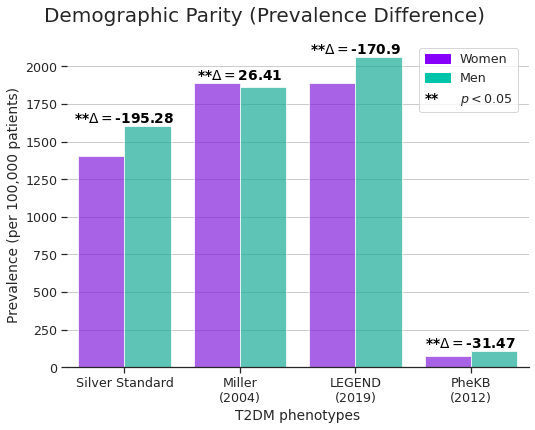

In [383]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'T2DM phenotypes': column_names, 
                         'women': [x[0] * 100000 for x in all_vals_dp], 
                         'men': [x[1] * 100000 for x in all_vals_dp]})

dfs1 = pd.melt(dfs, id_vars = "T2DM phenotypes", var_name='gender', value_name='Prevalence (per 100,000 patients)')

men_silver = len(full_df[full_df.gender_concept_id == 8507].subject_id.unique()) / men_total * 100000
women_silver = len(full_df[full_df.gender_concept_id == 8532].subject_id.unique()) / women_total * 100000

count = np.array([len(full_df[full_df.gender_concept_id == 8507].person_id.unique()), 
                  len(full_df[full_df.gender_concept_id == 8532].person_id.unique())])
nobs = np.array([men_total, women_total])
stat, pval_silver = proportions_ztest(count, nobs)


tmp = dfs1.append({'T2DM phenotypes' : 'Silver Standard', 'gender' : 'women', 'Prevalence (per 100,000 patients)' : women_silver}, ignore_index=True)
tmp = tmp.append({'T2DM phenotypes' : 'Silver Standard', 'gender' : 'men', 'Prevalence (per 100,000 patients)' : men_silver}, ignore_index=True)

category_order = ["Silver Standard", "Miller\n(2004)", "LEGEND\n(2019)", "PheKB\n(2012)"]

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'T2DM phenotypes', y='Prevalence (per 100,000 patients)', 
               hue = 'gender', data=tmp, kind='bar', order = category_order,
               palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(women_silver, xmin=0, xmax=3, linestyle = '--', color = '#8700f9', label = 'silver standard (women)')
# plt.axhline(men_silver, xmin=0, xmax=3, linestyle = '--', color = '#00c4aa', label = 'silver standard (men)')

# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Demographic Parity (Prevalence Difference)')


# plt.text(0, 1910, "$\Delta = $" + str(np.round(diffs_dp[0] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(1, 2075, "$\Delta = $" + str(np.round(diffs_dp[1] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(2, 125, "$\Delta = $" + str(np.round(diffs_dp[2] * 100000, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(2, 1650, "$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(0.03, all_vals_dp[0][1] * 100000, "]", horizontalalignment='center', size='medium', color='black', fontsize = 8)


# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
#labels=["women","men", "women silver standard", "men silver standard"])

if pval_silver < cutoff:
    plt.text(0, np.round(max(women_silver, men_silver), 0) + 25, "**$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black', weight='bold')
else:
    plt.text(0, np.round(max(women_silver, men_silver), 0) + 25, "$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black')
    
for i, ele in enumerate(all_vals_dp):
    part1 = "$\Delta = $" + str(np.round(diffs_dp[i] * 100000, 2))
    part2 = "$p = $" + str(np.round(pvals_dp[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_dp[i] < cutoff:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 25, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 25, part1, horizontalalignment='center', size='medium', color='black')

plt.legend([patch1, patch2, obj_0], ['Women', 'Men', '$p < 0.05$'],
   handler_map={obj_0:AnyObjectHandler()}, bbox_to_anchor=(0.75, 1), loc='upper left', ncol=1)
        
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

plt.savefig('../png/t2dm_demographic_parity_legend.png', dpi=300, bbox_inches = 'tight')
plt.show()


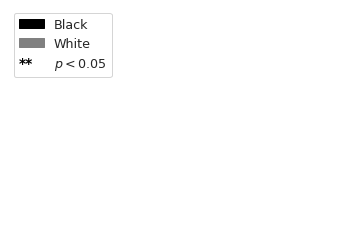

In [384]:
fig, ax = plt.subplots()
# ax.plot(range(10))

fig.patch.set_visible(False)
ax.axis('off')

# manually define a new patch 
# https://stackoverflow.com/questions/27174425/how-to-add-a-string-as-the-artist-in-matplotlib-legend
import matplotlib.text as mpl_text
import matplotlib.patches as mpatches

class AnyObject(object):
    def __init__(self, text, color):
        self.my_text = text
        self.my_color = color

class AnyObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        print(orig_handle)
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpl_text.Text(x=0, y=0, text=orig_handle.my_text, color=orig_handle.my_color,
                                verticalalignment=u'baseline', weight='bold',
                                horizontalalignment=u'left', multialignment=None, 
                                fontproperties=None, rotation=0, linespacing=None, 
                                rotation_mode=None)
        handlebox.add_artist(patch)
        return patch

obj_0 = AnyObject("**", "black")
# obj_1 = AnyObject("B", "green")

patch1 = mpatches.Patch(color='black', label='Black')
patch2 = mpatches.Patch(color='grey', label='white')


final = [handles[idx] for idx in order].append(obj_0)
other = [labels[idx] for idx in order].append('$p < 0.05$')

plt.legend([patch1, patch2, obj_0], ['Black', 'White', '$p < 0.05$'],
           handler_map={obj_0:AnyObjectHandler()}, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

# plt.savefig('../png/legend_Black_white.png', dpi=300, bbox_inches = 'tight')

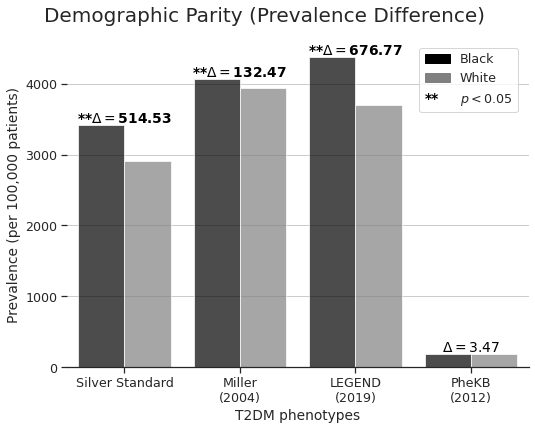

In [387]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'T2DM phenotypes': column_names, 
                         'Black': [x[0] * 100000 for x in all_vals_dp_race], 
                         'white': [x[1] * 100000 for x in all_vals_dp_race]})

dfs1 = pd.melt(dfs, id_vars = "T2DM phenotypes", var_name='race', value_name='Prevalence (per 100,000 patients)')

white_silver = len(full_df[full_df.race_source_concept_id == 4.0].subject_id.unique()) / white_total * 100000
black_silver = len(full_df[full_df.race_source_concept_id == 3.0].subject_id.unique()) / Black_total * 100000

count = np.array([len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique()), 
                  len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique())])
nobs = np.array([white_total, Black_total])
stat, pval_silver = proportions_ztest(count, nobs)


tmp = dfs1.append({'T2DM phenotypes' : 'Silver Standard', 'race' : 'Black', 'Prevalence (per 100,000 patients)' : black_silver}, ignore_index=True)
tmp = tmp.append({'T2DM phenotypes' : 'Silver Standard', 'race' : 'white', 'Prevalence (per 100,000 patients)' : white_silver}, ignore_index=True)

category_order = [x for x in column_names]
category_order.insert(0, "Silver Standard")

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'T2DM phenotypes', y='Prevalence (per 100,000 patients)', 
               hue = 'race', data=tmp, kind='bar', order = category_order,
               palette=sns.color_palette(['black', 'grey']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(black_silver, xmin=0, xmax=3, linestyle = '--', color = 'black', label = 'silver standard (Black)')
# plt.axhline(white_silver, xmin=0, xmax=3, linestyle = '--', color = 'grey', label = 'silver standard (white)')

# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Demographic Parity (Prevalence Difference)')


# plt.text(0, 4100, "$\Delta = $" + str(np.round(diffs_dp_race[0] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(1, 4450, "$\Delta = $" + str(np.round(diffs_dp_race[1] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(2, 250, "$\Delta = $" + str(np.round(diffs_dp_race[2] * 100000, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(2, 3500, "$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(0.03, all_vals_dp[0][1] * 100000, "]", horizontalalignment='center', size='medium', color='black', fontsize = 8)


# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
#labels=["women","men", "women silver standard", "men silver standard"])

if pval_silver < cutoff:
    plt.text(0, np.round(max(black_silver, white_silver), 0) + 25, "**$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black', weight='bold')
else:
    plt.text(0, np.round(max(black_silver, white_silver), 0) + 25, "$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black')
    
for i, ele in enumerate(all_vals_dp_race):
    part1 = "$\Delta = $" + str(np.round(diffs_dp_race[i] * 100000, 2))
    part2 = "$p = $" + str(np.round(p_vals_dp_race[i], 4))
    full_str = part1 + '\n' + part2 
    if p_vals_dp_race[i] < cutoff:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 25, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 25, part1, horizontalalignment='center', size='medium', color='black')

plt.legend([patch1, patch2, obj_0], ['Black', 'White', '$p < 0.05$'],
           handler_map={obj_0:AnyObjectHandler()}, bbox_to_anchor=(0.75, 1), loc='upper left', ncol=1)
        
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

plt.savefig('../png/t2dm_demographic_parity_race_legend.png', dpi=300, bbox_inches = 'tight')
plt.show()
